In [27]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import shap


In [28]:
# Load your data
df = pd.read_csv('/path/to/data/file.csv')

# Optional: Work with a subset of the data if you face memory issues
df_subset = df.sample(n=100000, random_state=42)
df = df_subset  # Use df for further processing

# Check for missing values
print(df.isnull().sum())

# Remove columns with all missing values
df = df.drop(columns=['NumberOfVehiclesInFleet', 'CustomValueEstimate', 'NewVehicle', 'WrittenOff', 'Rebuilt', 'Converted', 'CrossBorder'])

# Separate numerical and categorical columns
num_cols = df.select_dtypes(include=[np.number]).columns
cat_cols = df.select_dtypes(exclude=[np.number]).columns

# Ensure 'TransactionMonth' is not dropped
if 'TransactionMonth' in cat_cols:
    cat_cols = cat_cols.drop('TransactionMonth')



/home/enat/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3577: DtypeWarning: Columns (32,37) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


UnderwrittenCoverID              0
PolicyID                         0
TransactionMonth                 0
IsVATRegistered                  0
Citizenship                      0
LegalType                        0
Title                            0
Language                         0
Bank                          4051
AccountType                   4051
MaritalStatus                    0
Gender                           0
Country                          0
Province                         0
PostalCode                       0
MainCrestaZone                   0
SubCrestaZone                    0
ItemType                         0
mmcode                          44
VehicleType                     44
RegistrationYear                 0
make                            44
Model                           44
Cylinders                       44
cubiccapacity                   44
kilowatts                       44
bodytype                        44
NumberOfDoors                   44
VehicleIntroDate    

In [31]:
# Create imputer instances
imputer_num = SimpleImputer(strategy='median')
imputer_cat = SimpleImputer(strategy='most_frequent')

# Impute numerical columns
df_num_imputed = pd.DataFrame(imputer_num.fit_transform(df[num_cols]), columns=num_cols)

# Impute categorical columns excluding 'TransactionMonth'
df_cat_imputed = pd.DataFrame(imputer_cat.fit_transform(df[cat_cols]), columns=cat_cols)

# Retain the 'TransactionMonth' column
df_cat_imputed['TransactionMonth'] = df['TransactionMonth']

# Concatenate imputed numerical and categorical columns
df_imputed = pd.concat([df_num_imputed, df_cat_imputed], axis=1)

# Drop rows with any remaining NaN values 
df_imputed = df_imputed.dropna() 

# Verify that missing values are handled 
print(df_imputed.isnull().sum().sum()) # Should print 0


0


In [32]:
#Feature Engineering
df_imputed['PolicyDuration'] = pd.to_datetime(df['TransactionMonth']).apply(lambda x: 2025 - x.year)

# Verify new features
print(df_imputed[['TransactionMonth', 'PolicyDuration']].head())


       TransactionMonth  PolicyDuration
0   2015-03-01 00:00:00              10
12  2015-02-01 00:00:00              10
14  2015-03-01 00:00:00              10
18  2014-11-01 00:00:00              11
31  2015-03-01 00:00:00              10


In [34]:
#Encoding categorical data
df_imputed = pd.get_dummies(df_imputed, drop_first=True)

# Verify encoding
print(df_imputed.head())


    UnderwrittenCoverID  PolicyID  PostalCode      mmcode  RegistrationYear  \
0              167791.0   14494.0      1884.0  47048275.0            2015.0   
12              14634.0     287.0      1818.0  44046051.0            2003.0   
14             223550.0   16219.0      5320.0  60058407.0            2014.0   
18              32863.0     798.0       299.0  60058418.0            2011.0   
31              18219.0     981.0      2744.0  56220250.0            2013.0   

    Cylinders  cubiccapacity  kilowatts  NumberOfDoors  SumInsured  ...  \
0         4.0         2488.0      108.0            4.0     7500.00  ...   
12        4.0         1796.0      105.0            4.0        0.01  ...   
14        4.0         2494.0       75.0            4.0     5000.00  ...   
18        4.0         2694.0      111.0            4.0     3500.00  ...   
31        4.0         2499.0      100.0            5.0    35000.00  ...   

    TransactionMonth_2014-11-01 00:00:00  \
0                             

In [35]:
#Train test split
# Define target variables and features
X = df_imputed.drop(columns=['TotalPremium', 'TotalClaims'])
y_total_premium = df_imputed['TotalPremium']
y_total_claims = df_imputed['TotalClaims']

# Split the data
X_train_premium, X_test_premium, y_train_premium, y_test_premium = train_test_split(X, y_total_premium, test_size=0.3, random_state=42)
X_train_claims, X_test_claims, y_train_claims, y_test_claims = train_test_split(X, y_total_claims, test_size=0.3, random_state=42)


In [36]:
#Linear regression
lr = LinearRegression()
lr.fit(X_train_premium, y_train_premium)
y_pred_premium = lr.predict(X_test_premium)
print("Linear Regression - TotalPremium")
print("Mean Squared Error:", mean_squared_error(y_test_premium, y_pred_premium))
print("R2 Score:", r2_score(y_test_premium, y_pred_premium))


Linear Regression - TotalPremium
Mean Squared Error: 13944.804053180103
R2 Score: 0.3902178608758262


In [22]:
#Decision trees
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train_premium, y_train_premium)
y_pred_premium = dt.predict(X_test_premium)
print("Decision Tree - TotalPremium")
print("Mean Squared Error:", mean_squared_error(y_test_premium, y_pred_premium))
print("R2 Score:", r2_score(y_test_premium, y_pred_premium))


Decision Tree - TotalPremium
Mean Squared Error: 16407.55676756888
R2 Score: 0.2825259483479208


In [23]:
# Random forests
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train_premium, y_train_premium)
y_pred_premium = rf.predict(X_test_premium)
print("Random Forest - TotalPremium")
print("Mean Squared Error:", mean_squared_error(y_test_premium, y_pred_premium))
print("R2 Score:", r2_score(y_test_premium, y_pred_premium))


Random Forest - TotalPremium
Mean Squared Error: 9638.391350632533
R2 Score: 0.5785298328258458


In [38]:
# Define target variables and features
X = df_imputed.drop(columns=['TotalPremium', 'TotalClaims'])
y_total_premium = df_imputed['TotalPremium']
y_total_claims = df_imputed['TotalClaims']

# Convert to NumPy arrays for XGBoost compatibility
X = X.values
y_total_premium = y_total_premium.values
y_total_claims = y_total_claims.values

# Split the data
X_train_premium, X_test_premium, y_train_premium, y_test_premium = train_test_split(X, y_total_premium, test_size=0.3, random_state=42)
X_train_claims, X_test_claims, y_train_claims, y_test_claims = train_test_split(X, y_total_claims, test_size=0.3, random_state=42)


In [39]:
# Gradient boosting machines
xgbr = xgb.XGBRegressor(random_state=42)
xgbr.fit(X_train_premium, y_train_premium)

# Predictions and Evaluation
y_pred_premium = xgbr.predict(X_test_premium)
print("XGBoost - TotalPremium")
print("Mean Squared Error:", mean_squared_error(y_test_premium, y_pred_premium))
print("R2 Score:", r2_score(y_test_premium, y_pred_premium))


XGBoost - TotalPremium
Mean Squared Error: 10196.892278100366
R2 Score: 0.5541075541795923


In [40]:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{model_name} - Mean Squared Error: {mse}")
    print(f"{model_name} - R2 Score: {r2}")

# Evaluate models
evaluate_model(lr, X_test_premium, y_test_premium, "Linear Regression")
evaluate_model(dt, X_test_premium, y_test_premium, "Decision Tree")
evaluate_model(rf, X_test_premium, y_test_premium, "Random Forest")
evaluate_model(xgbr, X_test_premium, y_test_premium, "XGBoost")


Linear Regression - Mean Squared Error: 13944.804053180103
Linear Regression - R2 Score: 0.3902178608758262
Decision Tree - Mean Squared Error: 16407.55676756888
Decision Tree - R2 Score: 0.2825259483479208
Random Forest - Mean Squared Error: 9638.391350632533
Random Forest - R2 Score: 0.5785298328258458
XGBoost - Mean Squared Error: 10196.892278100366
XGBoost - R2 Score: 0.5541075541795923


/home/enat/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/enat/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/enat/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [42]:
# Using SHAP for Random Forest
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_train_premium)

# Visualize the first prediction's explanation
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0, :], X_train_premium[0, :])


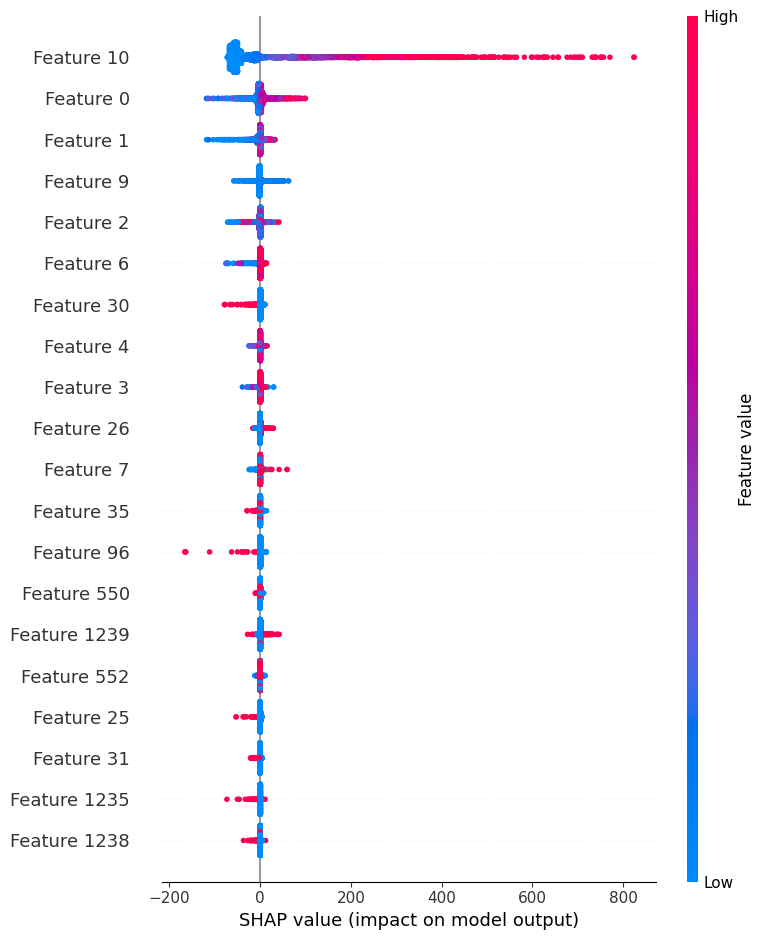

In [43]:
import matplotlib.pyplot as plt

# Set the figure size to make the plot more readable
plt.figure(figsize=(15, 10))
shap.summary_plot(shap_values, X_train_premium)
